# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math as ma
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
from astropy import units as u
import astropy 
from scipy.interpolate import interp1d

from scipy.io import readsav

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import igm

import gc
import linecache
import glob
import re

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [3]:
gc.collect()

0

In [4]:
np.set_printoptions(linewidth=100)
labelsize=20

# Load Schaerer

In [8]:
# jwstFilters   = lf.loadJWSTFilters(suppress=True)
# hubbleFilters = lf.loadHubbleFilters(suppress=True)
# jhkFilters    = lf.loadJHKFilters(suppress=True)

lamRange      = np.logspace(1.95,5.7,5500)

schaererPath = '/Users/earnric/OneDrive/Software-Models/Schaerer/'
schaererDirs = ['pop3_TA/','pop3_TE/','e-70_mar08/','e-50_mar08/']
# schaererDirs = ['pop3_TAtest/']
Zs           = [0.0, 0.0, 1.0e-7, 1.0e-5]
schaererPopFilePattern  = 'pop3_ge0_log?_500_001_is5.[0-9]*' # is5 files have ages in step of 1 Myr
schaererLowZFilePattern = 'e-?0_sal_100_001_is2.[0-9]*'      # is2 files have ages in step of 0.05 dex

# Load the schaerer files... 
# Note that due to spacing (in age), there are sometimes two files that 
# are SEDS for the same time-stamp! Skip the second one (and third!)
lastAge = 0.0
for i, (Z, schaererDir) in enumerate(zip(Zs,schaererDirs)):
    if schaererDir.startswith('pop3'):
        schaererFilePattern = schaererPath + schaererDir + schaererPopFilePattern  # Pop III files, 1 Myr spacing
    else:
        schaererFilePattern = schaererPath + schaererDir + schaererLowZFilePattern # Low Z files, 0.05 dex spacing

    schaererFiles   = glob.glob(schaererFilePattern)  # All the files in the dir... 
    schaererFiles   = [a for a in schaererFiles if not re.search('\.[1-2][0-9][b]*$', a)] # remove .1? and .2? files
    schaererAges    = [linecache.getline(file,13) for file in schaererFiles]    # Get the line with the (log) age... 
    schaererAges    = np.array([float(sa[30:]) for sa in schaererAges],dtype=float)         # Log age starts at position 30

    schaererData    = np.array([np.loadtxt(file,skiprows=16) for file in schaererFiles])
    ageSortIndxes   = schaererAges.argsort()          # Array of indices to sort things by age...
    
    schaererData    = schaererData[ageSortIndxes]
    schaererAges    = schaererAges[ageSortIndxes]
    print(schaererAges)

    # Ignore data files with the same age! This occurs in the popIII dirs
    # because the timestep is smaller than the age-resolution printed in the file
    # Hence we get 2 files with different data but the same time stamp
    lastAge = 0.0
    schaererDataGood = []
    schaererAgesGood = []
    for ii,(sd,age) in enumerate(zip(schaererData,schaererAges)):
        if age == lastAge:
            # Remove it
            continue
        lastAge = age
        schaererDataGood.append(sd)
        schaererAgesGood.append(float(age))
    
    # The following builds an array of arrays (one for each age) with each array's entries:
    # log age, Z, waveln, lum/A
    allSchaererData = [np.insert(sed[:,[0,2]],[0],[[anAge] for ii in range(0,len(sed))], axis=1) 
        for anAge,sed in zip(schaererAgesGood, schaererDataGood)]
    allSchaererData = np.array(allSchaererData).reshape(len(allSchaererData)*len(allSchaererData[0]),3)
    if i == 0:
        pop3TA = allSchaererData # may need a np.copy(...) here... ??
    elif i == 1:
        pop3TE = allSchaererData
    elif i == 2:
        Zem7 = allSchaererData
    elif i == 3:
        Zem5 = allSchaererData
    # We now have:
    # [[log age, waveln, flux], [], ...]

1001
1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
1001
1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
112
112 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55
  5.6   5.65  5.7   5.75  5.8   5.85  5.9   5.95  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35
  6.4   6.45  6.5   6.55  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95  7.    7.05  7.1   7.15
  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55  7.6   7.65  7.7   7.75  7.8   7.85  7.9   7.95  8.
  8.05  8.1   8.15  8.2   8.25  8.3   8.35  8.4   8.45  8.5   8.55  8.6   8.65  8.7   8.75  8.8
  8.85  8.9   8.95  9.    9.05  9.1   9.15  9.2   9.25  9.3   9.35  9.4   9.45  9.5   9.55]
114
114 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35  5.4   5.45  5.5   

In [90]:
pop3TA_ages    = pop3TA[:,0]
pop3TA_wavelns = pop3TA[:,1] * u.Angstrom
pop3TA_LperA   = pop3TA[:,2] * u.erg / u.second / u.angstrom

Zem7_ages    = Zem7[:,0]
Zem7_wavelns = Zem7[:,1] * u.Angstrom
Zem7_LperA   = Zem7[:,2] * u.erg / u.second / u.angstrom

Zem5_ages    = Zem5[:,0]
Zem5_wavelns = Zem5[:,1] * u.Angstrom
Zem5_LperA   = Zem5[:,2] * u.erg / u.second / u.angstrom


In [91]:
np.unique(pop3TA_ages)[0:10],np.unique(Zem7_ages)[40:60]

(array([ 4.   ,  6.004,  6.303,  6.479,  6.603,  6.7  ,  6.779,  6.846,  6.904,  6.955]),
 array([ 6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,  6.3 ,  6.35,  6.4 ,  6.45,  6.5 ,  6.55,  6.6 ,
         6.65,  6.7 ,  6.75,  6.8 ,  6.85,  6.9 ,  6.95]))

In [100]:
pop2wl  = pop3TA_wavelns[pop3TA_ages == 6.004]
pop3flux = pop3TA_LperA[pop3TA_ages == 6.004]

In [101]:
zem7wl   = Zem7_wavelns[Zem7_ages == 6.0]
zem7flux = Zem7_LperA[Zem7_ages == 6.0]
zem5wl   = Zem5_wavelns[Zem5_ages == 6.0]
zem5flux = Zem5_LperA[Zem5_ages == 6.0]

14611

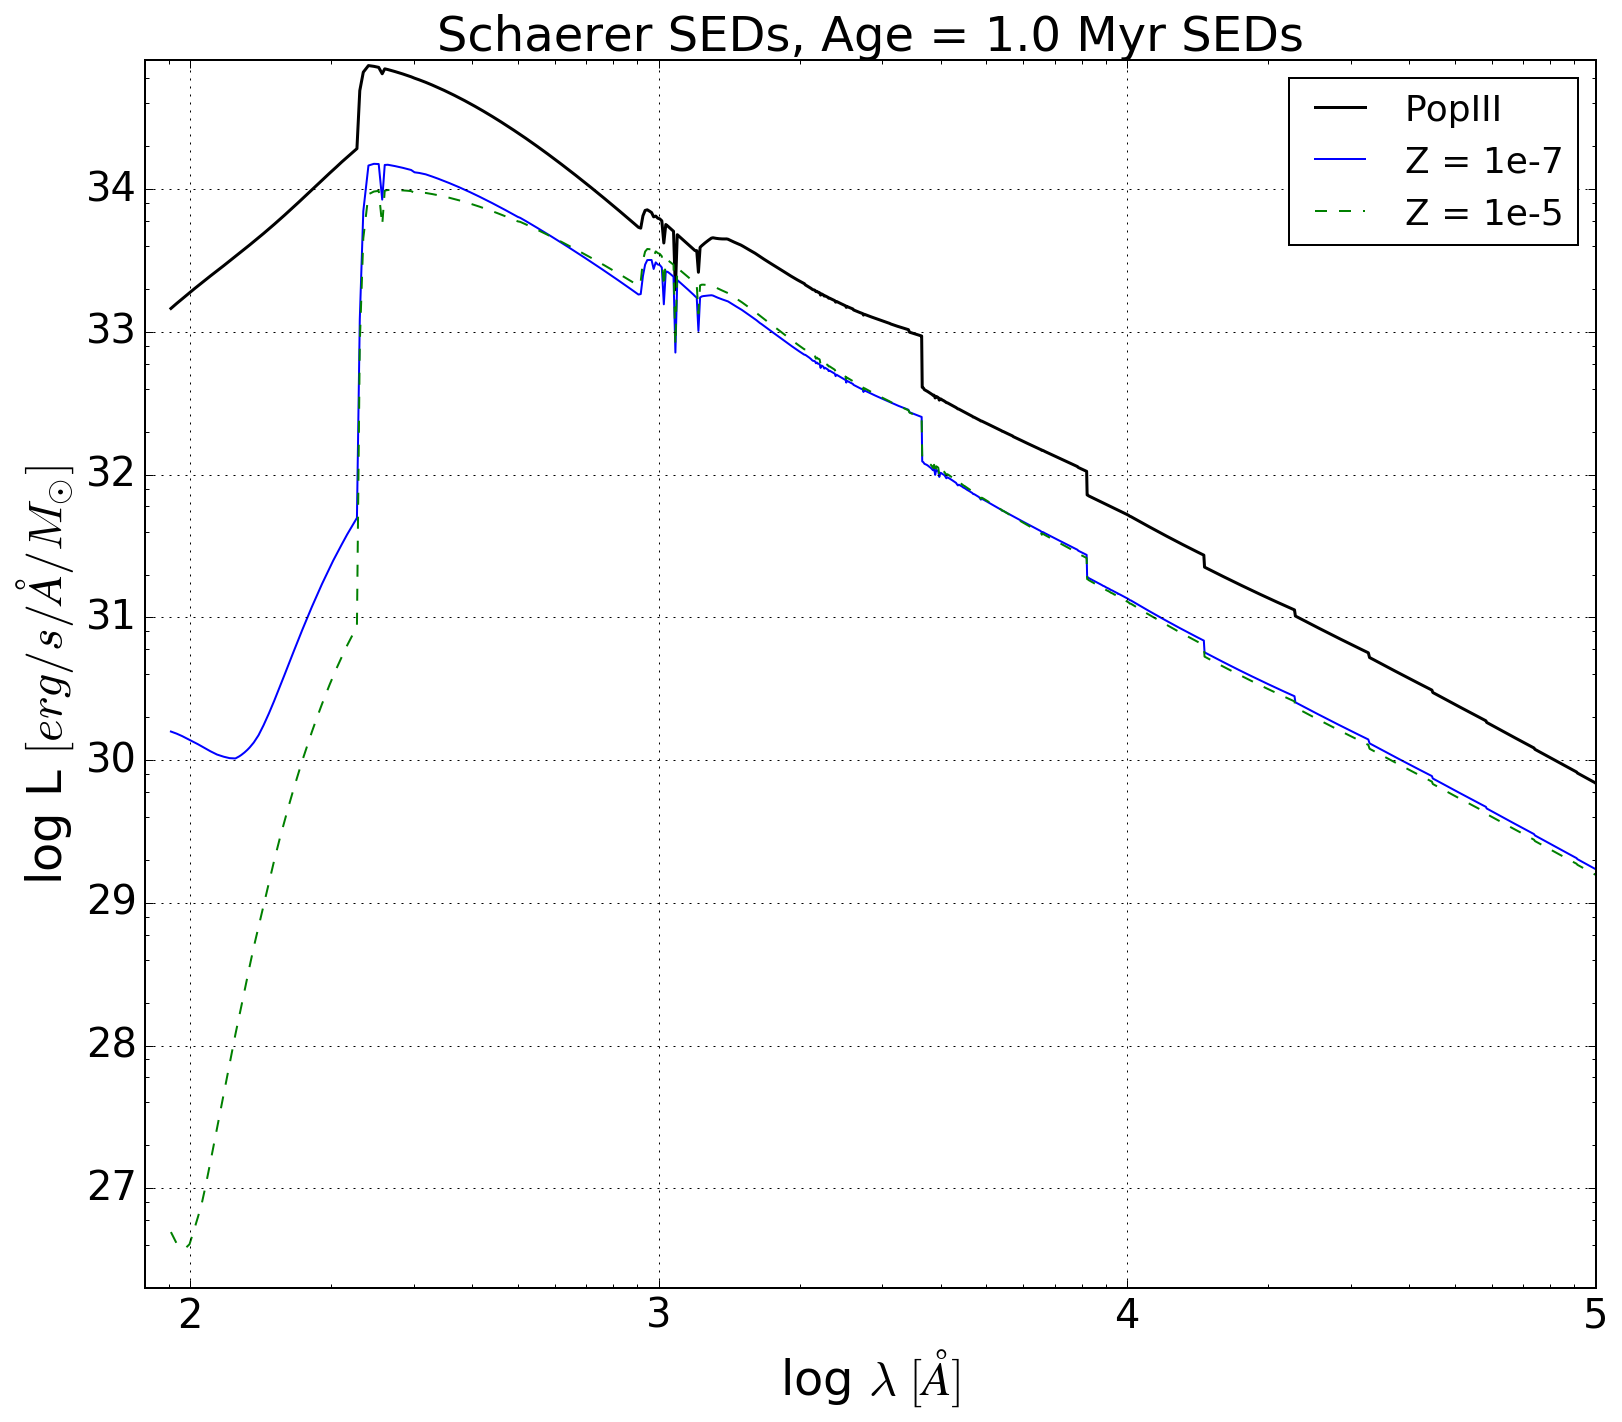

In [109]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(pop2wl,pop3flux,'k-',lw=1.5)
ax.plot(zem7wl,zem7flux,'b-')
ax.plot(zem5wl,zem5flux,'g--')

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([80,1e5])
ax.set_ylim([2e26,8e34])

ax.set_xlabel(r'log $\lambda\; [\AA]$', size=24)
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['PopIII','Z = 1e-7','Z = 1e-5'],
              loc='upper right', fontsize=18 )

#fig.suptitle('Pop III SEDs', fontsize=24)
ax.set_title('Schaerer SEDs, Age = %.1lf Myr SEDs'%(10**0), fontsize=24)
gc.collect()

14611

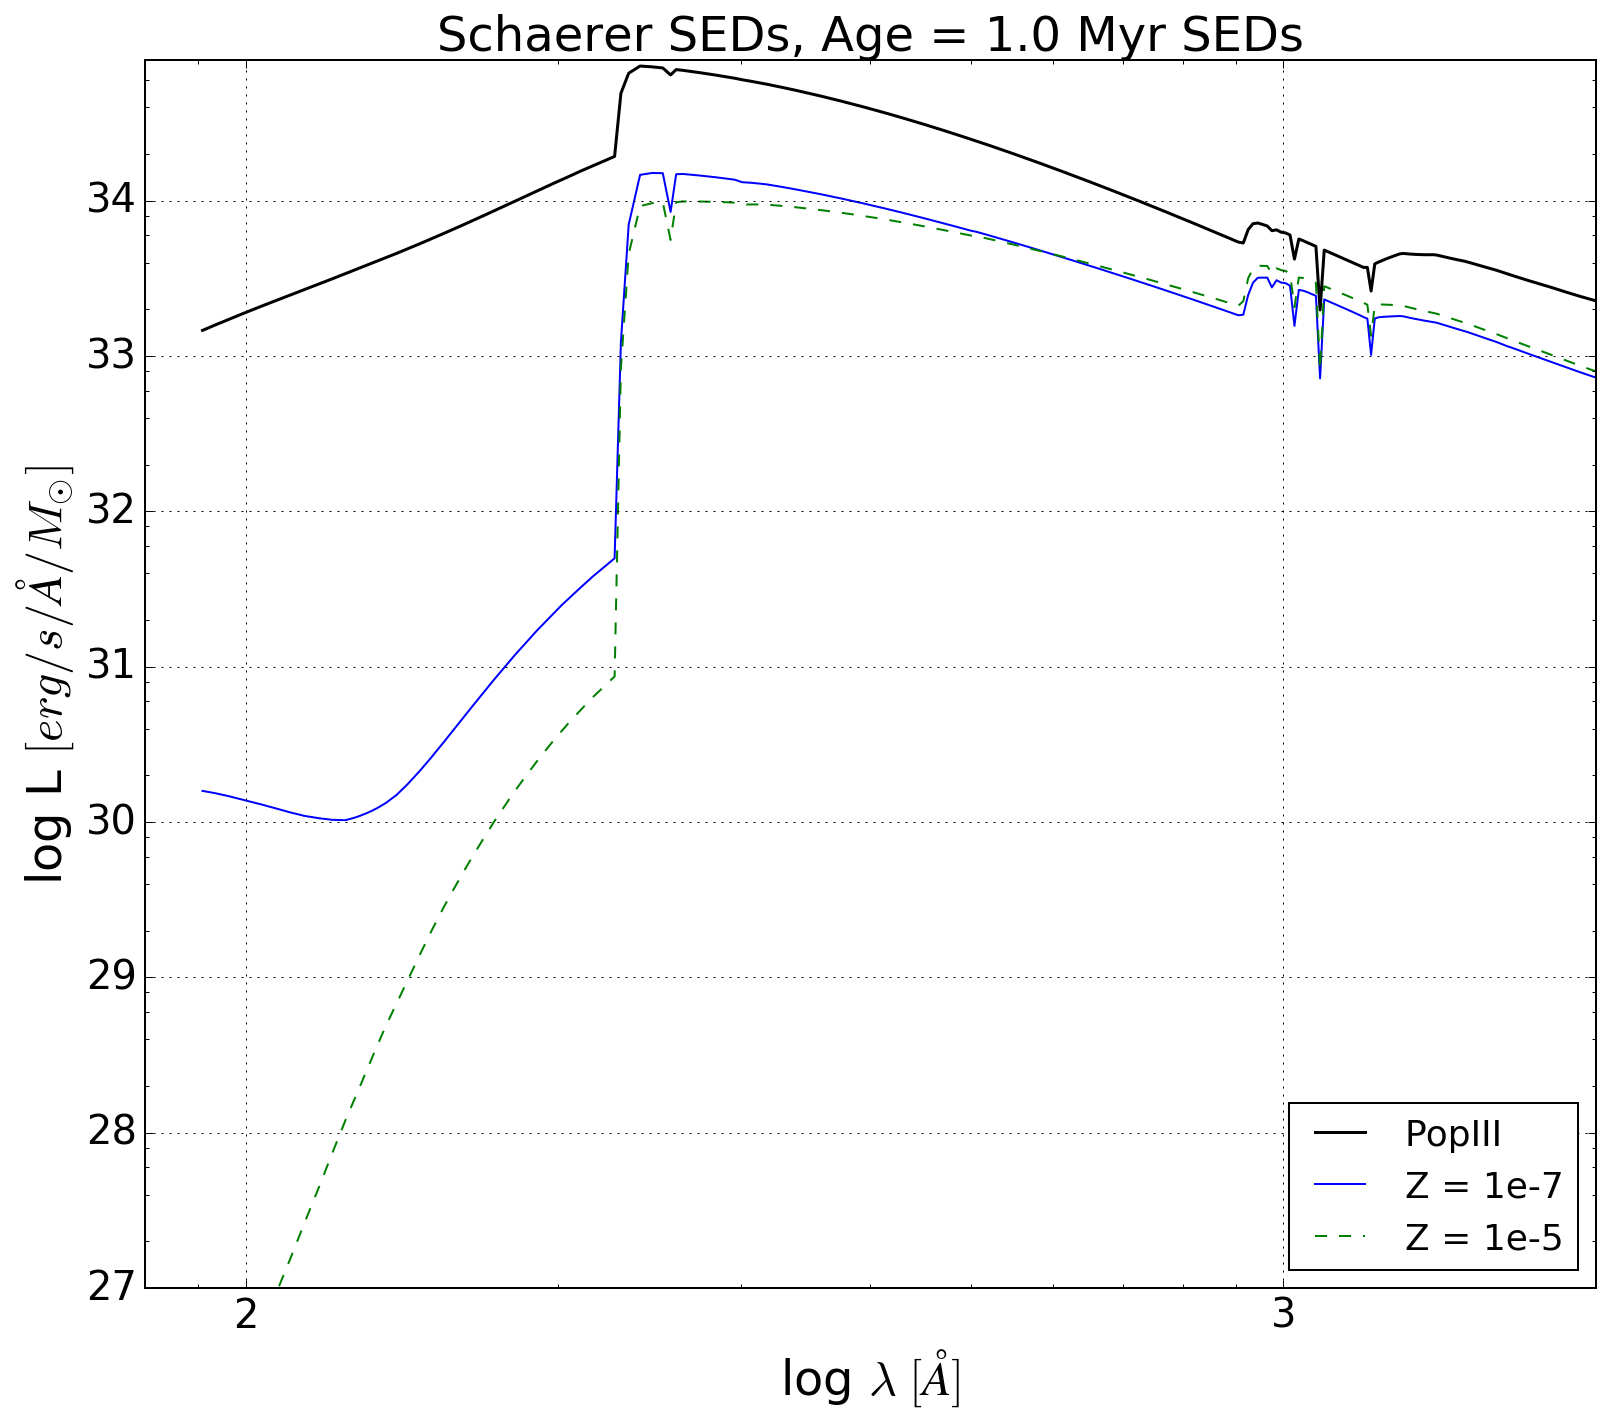

In [108]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(pop2wl,pop3flux,'k-',lw=1.5)
ax.plot(zem7wl,zem7flux,'b-')
ax.plot(zem5wl,zem5flux,'g--')

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([80,2e3])
ax.set_ylim([1e27,8e34])

ax.set_xlabel(r'log $\lambda\; [\AA]$', size=24)
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['PopIII','Z = 1e-7','Z = 1e-5'],
              loc='lower right', fontsize=18 )

#fig.suptitle('Pop III SEDs', fontsize=24)
ax.set_title('Schaerer SEDs, Age = %.1lf Myr SEDs'%(10**0.0), fontsize=24)
gc.collect()

In [96]:
np.unique(pop3TA_ages)[10:54],np.unique(Zem7_ages)[60:80]

(array([ 7.   ,  7.042,  7.08 ,  7.114,  7.146,  7.176,  7.204,  7.231,  7.256,  7.279,  7.301,
         7.322,  7.343,  7.362,  7.38 ,  7.398,  7.415,  7.432,  7.447,  7.463,  7.477,  7.492,
         7.505,  7.519,  7.532,  7.544,  7.556,  7.568,  7.58 ,  7.591,  7.602,  7.613,  7.623,
         7.634,  7.644,  7.653,  7.663,  7.672,  7.681,  7.69 ,  7.699,  7.708,  7.716,  7.724]),
 array([ 7.  ,  7.05,  7.1 ,  7.15,  7.2 ,  7.25,  7.3 ,  7.35,  7.4 ,  7.45,  7.5 ,  7.55,  7.6 ,
         7.65,  7.7 ,  7.75,  7.8 ,  7.85,  7.9 ,  7.95]))

In [97]:
pop3TA_ages    = pop3TA[:,0]
pop3TA_wavelns = pop3TA[:,1] * u.Angstrom
pop3TA_LperA   = pop3TA[:,2] * u.erg / u.second / u.angstrom

Zem7_ages    = Zem7[:,0]
Zem7_wavelns = Zem7[:,1] * u.Angstrom
Zem7_LperA   = Zem7[:,2] * u.erg / u.second / u.angstrom

Zem5_ages    = Zem5[:,0]
Zem5_wavelns = Zem5[:,1] * u.Angstrom
Zem5_LperA   = Zem5[:,2] * u.erg / u.second / u.angstrom

pop2wl  = pop3TA_wavelns[pop3TA_ages == 7]
pop3flux = pop3TA_LperA[pop3TA_ages == 7]
zem7wl   = Zem7_wavelns[Zem7_ages == 7]
zem7flux = Zem7_LperA[Zem7_ages == 7]
zem5wl   = Zem5_wavelns[Zem5_ages == 7]
zem5flux = Zem5_LperA[Zem5_ages == 7]

16551

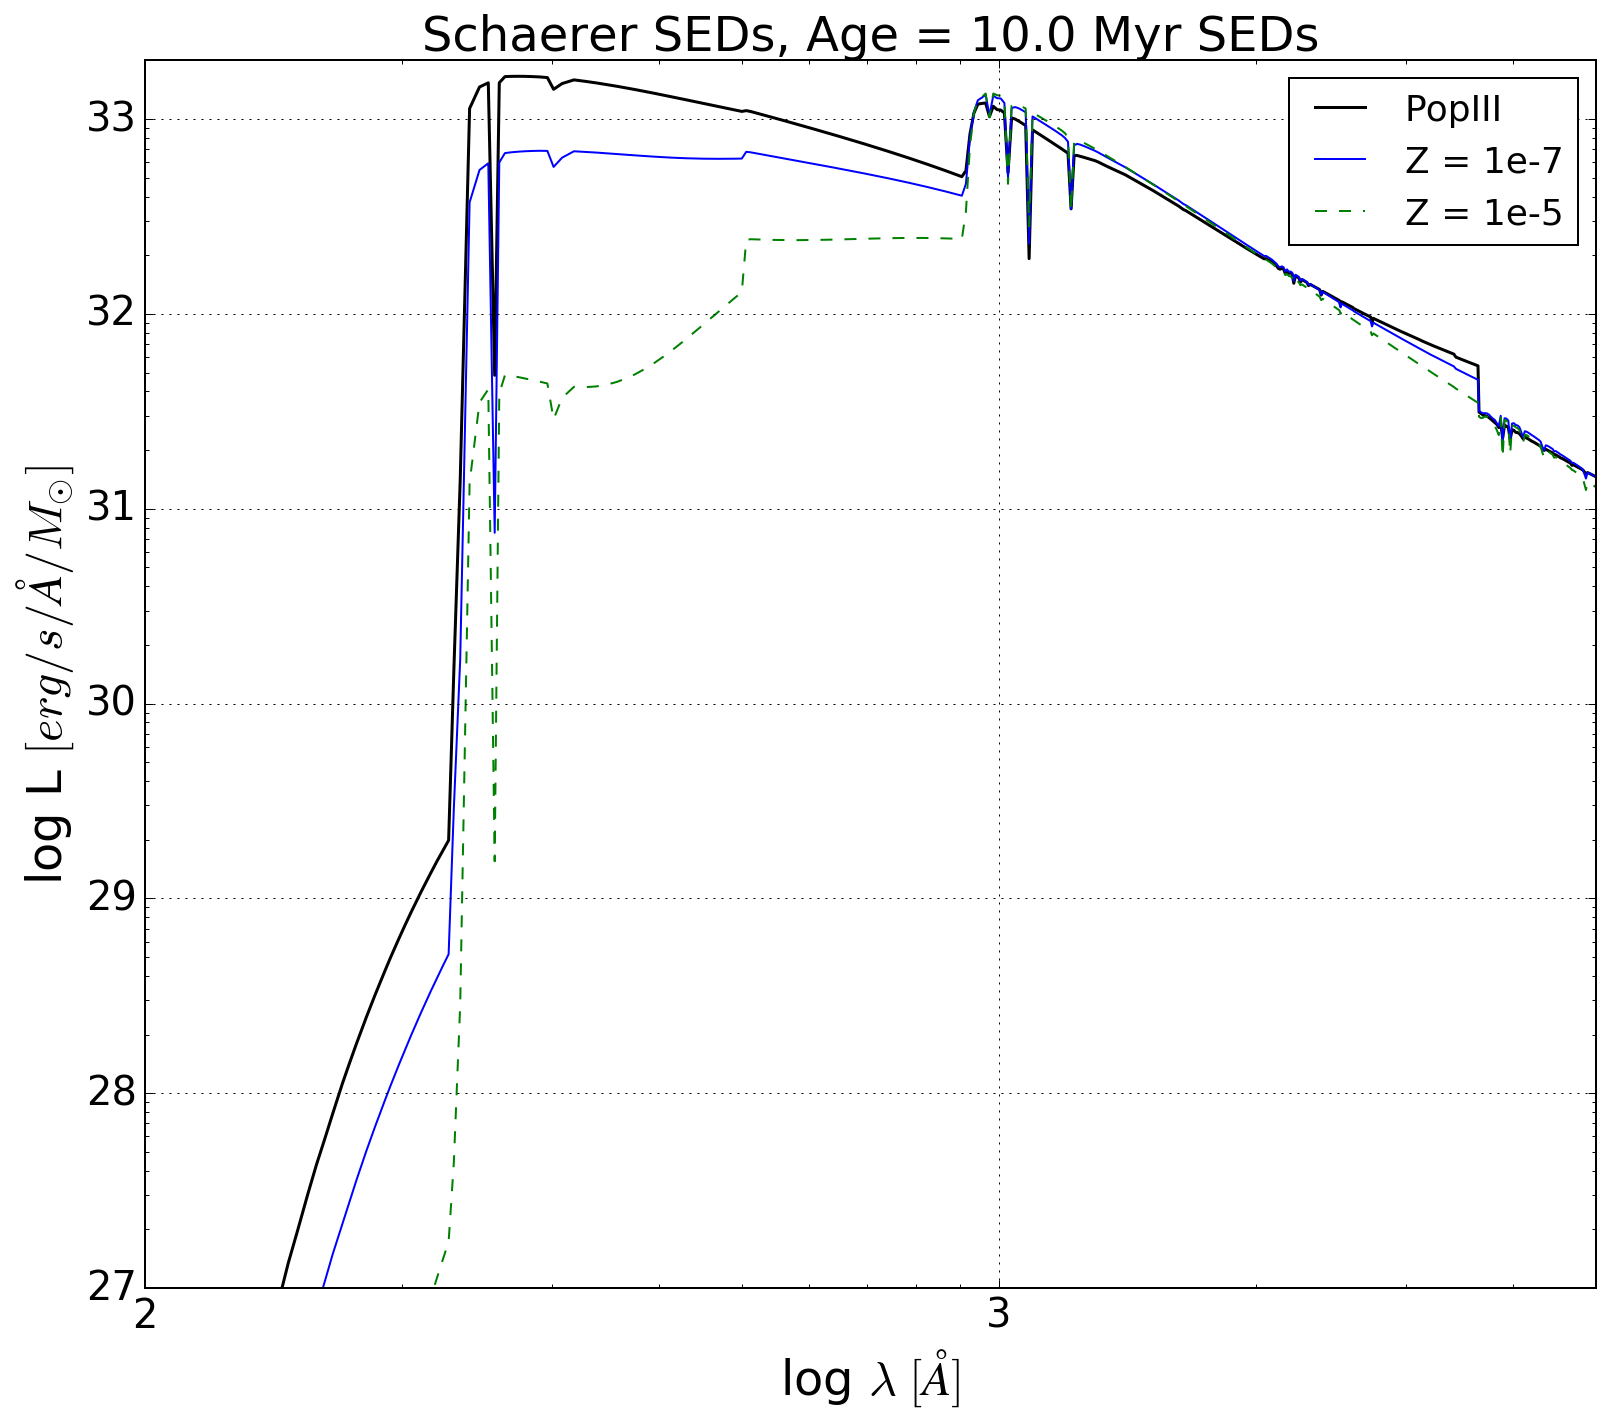

In [98]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(pop2wl,pop3flux,'k-',lw=1.5)
ax.plot(zem7wl,zem7flux,'b-')
ax.plot(zem5wl,zem5flux,'g--')

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([100,5e3])
ax.set_ylim([1e27,2e33])

ax.set_xlabel(r'log $\lambda\; [\AA]$', size=24)
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['PopIII','Z = 1e-7','Z = 1e-5'],
              loc='upper right', fontsize=18 )

#fig.suptitle('Pop III SEDs', fontsize=24)
ax.set_title('Schaerer SEDs, Age = %.1lf Myr SEDs'%(10**1), fontsize=24)
gc.collect()

27015

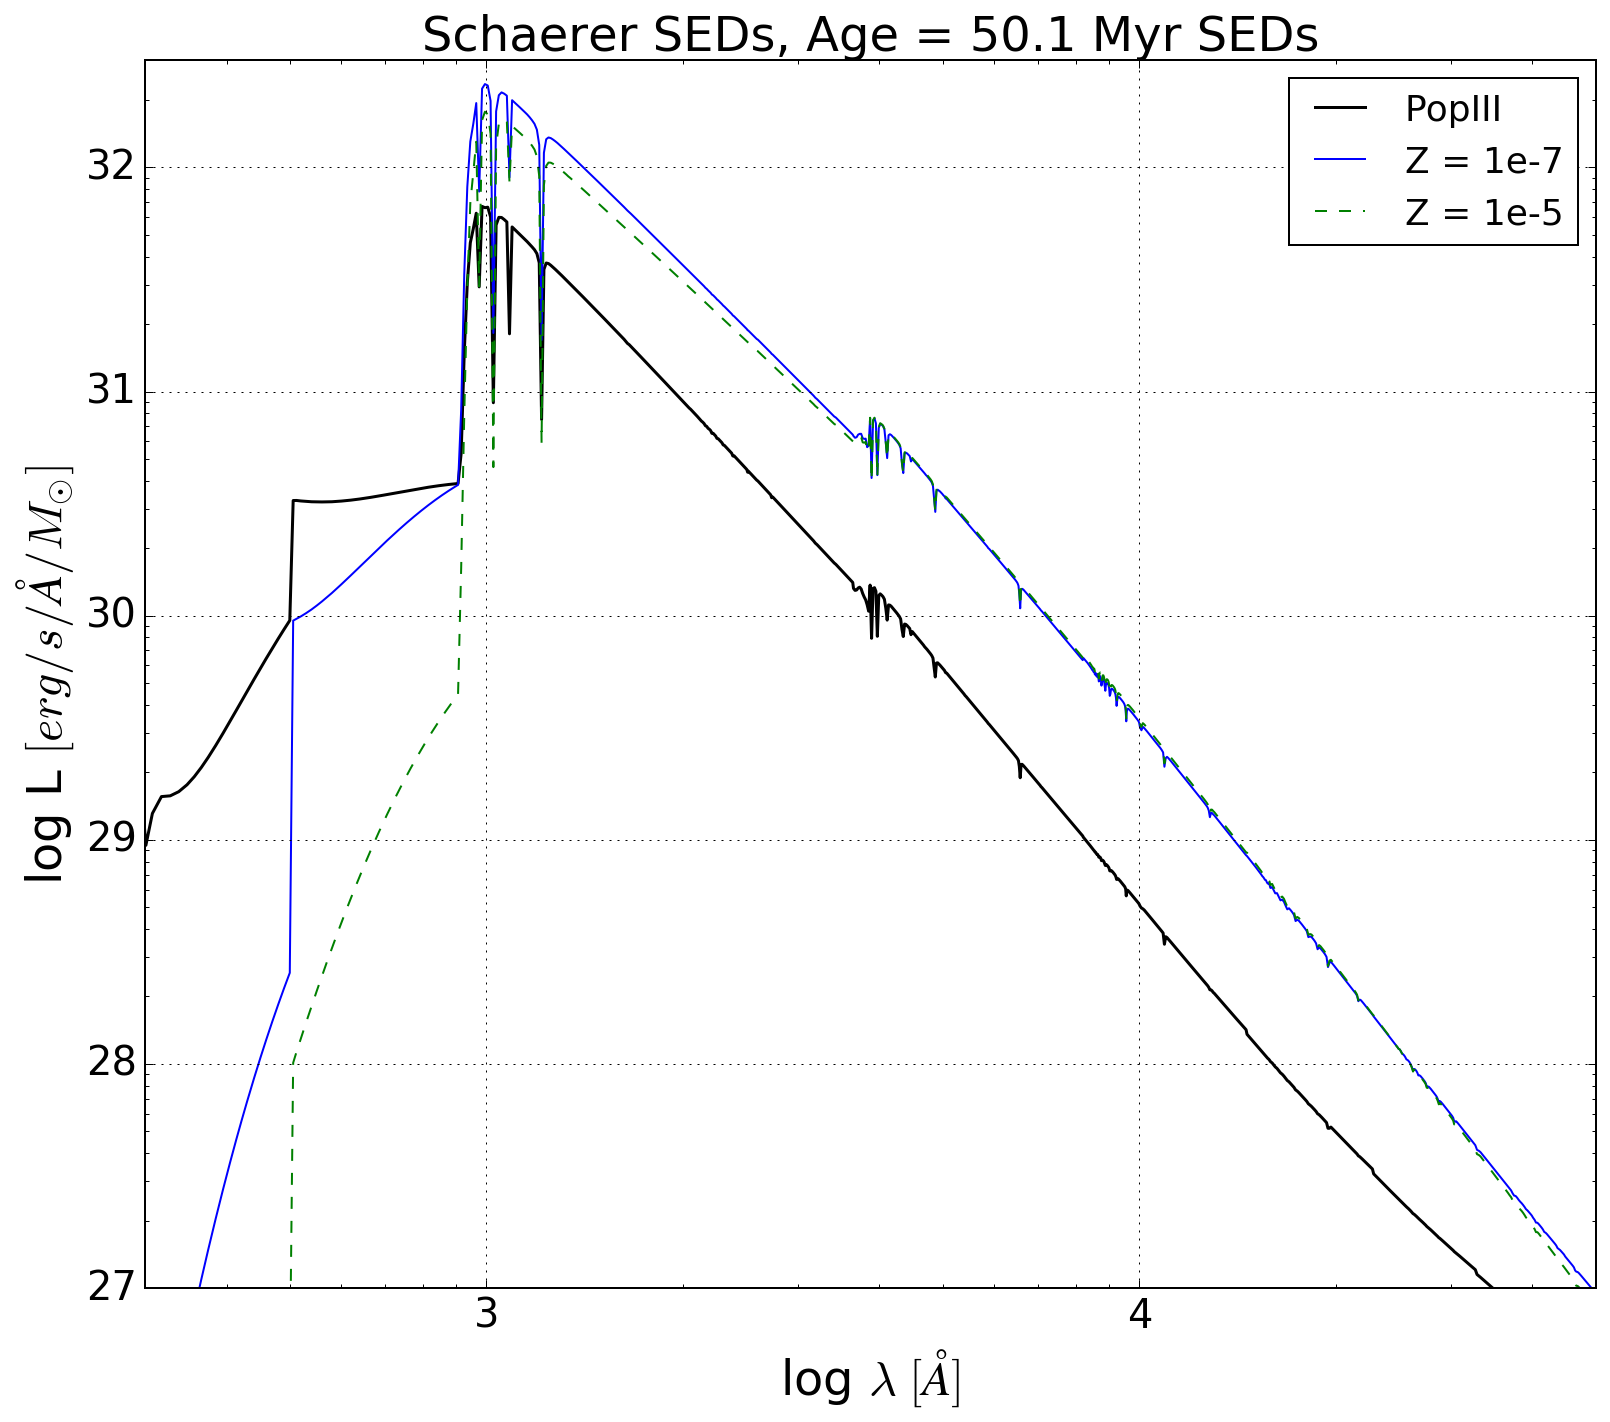

In [110]:
pop3TA_ages    = pop3TA[:,0]
pop3TA_wavelns = pop3TA[:,1] * u.Angstrom
pop3TA_LperA   = pop3TA[:,2] * u.erg / u.second / u.angstrom

Zem7_ages    = Zem7[:,0]
Zem7_wavelns = Zem7[:,1] * u.Angstrom
Zem7_LperA   = Zem7[:,2] * u.erg / u.second / u.angstrom

Zem5_ages    = Zem5[:,0]
Zem5_wavelns = Zem5[:,1] * u.Angstrom
Zem5_LperA   = Zem5[:,2] * u.erg / u.second / u.angstrom

pop2wl  = pop3TA_wavelns[pop3TA_ages == 7.699]
pop3flux = pop3TA_LperA[pop3TA_ages == 7.699]
zem7wl   = Zem7_wavelns[Zem7_ages == 7.7]
zem7flux = Zem7_LperA[Zem7_ages == 7.7]
zem5wl   = Zem5_wavelns[Zem5_ages == 7.7]
zem5flux = Zem5_LperA[Zem5_ages == 7.7]

fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(pop2wl,pop3flux,'k-',lw=1.5)
ax.plot(zem7wl,zem7flux,'b-')
ax.plot(zem5wl,zem5flux,'g--')

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([300,5e4])
ax.set_ylim([1e27,3e32])

ax.set_xlabel(r'log $\lambda\; [\AA]$', size=24)
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['PopIII','Z = 1e-7','Z = 1e-5'],
              loc='upper right', fontsize=18 )

#fig.suptitle('Pop III SEDs', fontsize=24)
ax.set_title('Schaerer SEDs, Age = %.1lf Myr SEDs'%(10**1.7), fontsize=24)
gc.collect()